In [1]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var)
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt
        xs.append(x)
        zs.append(x + randn() * z_std)
    return np.array(xs), np.array(zs)

In [14]:
# inicializar estados, posicion y velocidad
x = np.array([[10.0, 4.5]])

In [15]:
# diseñar matriz de covarianzas:
P = np.diag([500., 49])
P

array([[500.,   0.],
       [  0.,  49.]])

In [16]:
# diseñar process model, el comportamiento del sistema considero que el perro va a velocidad constante
# y que los cambios de velocidad se modelan con el ruido del proceso
dt = 0.1
F = np.array([[1, dt], [0,1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

In [17]:
# probando las cosas
from filterpy.kalman import predict
from filterpy.stats import plot_covariance_ellipse
# el método predict utiliza x- = Fx

In [18]:
# diseñand la matriz Q , se puede hacer con el toolkit que lo que hace es discretizar ruido gaussiano con delta t
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


In [20]:
# no hay matriz de control, hago B=0
B = 0
u = 0
x, P = predict(x.T, P, F, Q, B, u) # paso del filtro de Kalman
print(f"x: {x}")
print(f"p: {P}")

x: [[10.45]
 [ 4.5 ]]
p: [[501.0775   6.075 ]
 [  6.075   51.35  ]]


In [21]:
# ajustando H para convertir de array velocidad posicion a solo posición
H = np.array([[1., 0]])

In [30]:
R = np.array([[5.]]) # solo posición con covarianza de 5m2

In [32]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print(f" x={x}")

 x=[[1.09336515]
 [4.38656135]]


In [33]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


In [34]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """

    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [35]:


dt = .1
x = np.array([0., 0.])
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)



In [36]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x00000248FE2263A0>

In [38]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0,
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the
    corresponding measurements.
    """

    # Simulate dog if no data provided.
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov


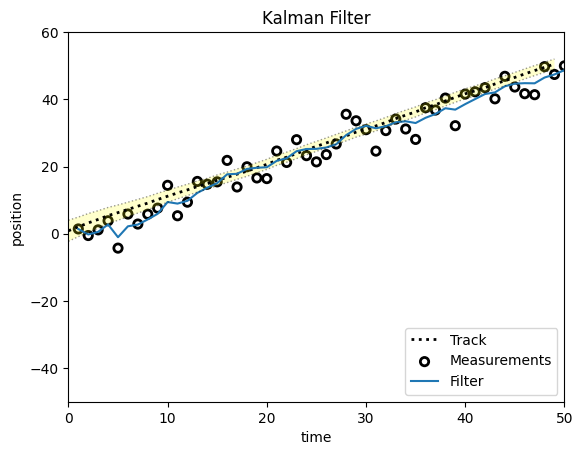

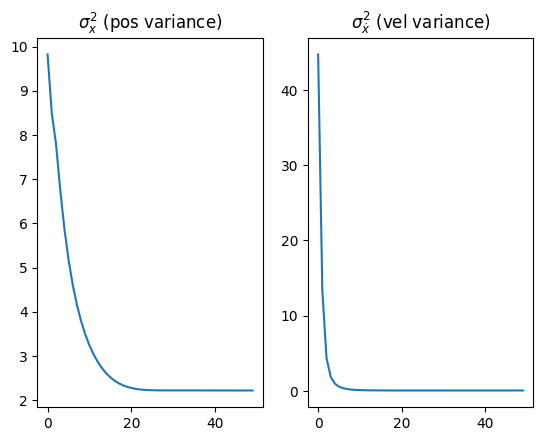

In [39]:


P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

